# Analysis.

In [1345]:
import pandas as pd
from pandas import json_normalize
import numpy as np

import requests 
import json
import os
from dotenv import load_dotenv #conda install -c conda-forge python-dotenv

import time
import importlib
import src.extraction as ex
importlib.reload(ex)

<module 'src.extraction' from 'd:\\ironhack\\proyectos\\PipeLine_proy2\\src\\extraction.py'>

## 1. USDA food database.
### 1.1. Exploration.

Did a research of all the USDA csv files and select only the more relevant for this proyect, they have a lot of information about comples dishes, lab tests, market prices, etc. 1. Searching for the right tables with value information for the proyect. 2. Cleaning each table, droping the columns and probably some rows with no need it information. ----try to merge it in python by changing the name of tha columns to the same in each. exported as csv 3. Merge the tables -- prbably on SQL exported again in csv and put it back on python.

#### 1.1.1. "Food csv".
Data frame of food, it has its id number and name of food.

In [1346]:
url = "D:\ironhack\proyectos\PipeLine_proy2\\USDA_main_csv\\food.csv"

In [1347]:
food = ex.import_csv (url)
food.sample()

,fdc_id,data_type,description,food_category_id,publication_date
615728,1188027,branded_food,BEEF TERIYAKI STIR-FRY TENDER BEEF WITH BROCCO...,NaN,2021-02-26


In [1348]:
food.shape

(1185090, 5)

##### 1.1.1.1. Deleting.
Will remove the "food_category_id", "data_type" and the "publication_date" column and try to remove the index column, it appears that it does not do much, it doest have a column name for identification

In [1349]:
food = ex.delete_food (food)
food

,fdc_id,description
0,1105904,WESSON Vegetable Oil 1 GAL
1,1105905,SWANSON BROTH BEEF
2,1105906,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER
3,1105907,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI
4,1105898,Discrepancy between the Atwater factor predict...
...,...,...
1185077,1757377,"MUSHROOMS, SHIITAKE"
1185078,1757378,"MUSHROOMS, SHIITAKE"
1185079,1757379,"MUSHROOMS, SHIITAKE"
1185080,1757380,"MUSHROOMS, SHIITAKE"


In [1350]:
food.duplicated().sum()

0

#### 1.1.2. "Nutrients Table".
In this table can relate the data of nutrients and in wich food they are. they specifie the mount of the nutrient per 100g of food. Specified in unit defined in the nutrient table.

In [1351]:
url2 = "D:\ironhack\proyectos\PipeLine_proy2\\USDA_main_csv\\nutrient.csv"
nutrient = ex.import_csv(url2)
nutrient.sample()

,id,name,unit_name,nutrient_nbr,rank
183,1186,Folic acid,UG,431.0,7000.0


In [1352]:
nutrient.shape

(463, 5)

##### 1.1.2.1. Deleting.
will delete must of the columns, except name and id, but will create a copy so i dont lose the information, could help me in the future.

In [1353]:
nutrient = ex.delete_nutrient (nutrient)
nutrient.sample()

,id,name
83,1085,Total fat (NLEA)


#### 1.1.3. "Food_id Nutrient_id"
This table doesn´t appear in the information docs, but it loocks really helfull allready matching the nutrient with the food and the portion per 100g. Wont delete any column, but will start to change names of each Data Frame to matched them later. 

In [1354]:
url3 = "D:\ironhack\proyectos\PipeLine_proy2\\USDA_main_csv\\JCS_FoodId-NutrientId-Per100g.csv"
ides = ex.import_csv (url3)
ides.sample()

,FoodId,NutrientId,Per100g
11881851,1546901,606,9.46


### 1.2. Merging.
Will merge all data frames into one, will chose the right tables for it and clean it more.

Looking for same elements in different tables at the ID rows, will change the names to matched them.

#### 1.2.1. Rename.

In [1355]:
# change decription to food
# change fdc_id to food_id
food.rename(columns= {"fdc_id" : "food_id", "description" : "food"}, inplace=True)
food.sample()

,food_id,food
500913,981133,"NATURAL PEANUT BUTTER WITH HONEY, CREAMY"


In [1356]:
#change NutrientId to nutrient_id
#change foodId to food_id
ides.rename(columns= {"FoodId" : "food_id", "NutrientId" : "nutrient_id", 'Per100g ' : "Per100g"}, inplace=True)
ides.sample()

,food_id,nutrient_id,Per100g
13813336,1621497,303,1.2


In [1357]:
# change id to nutrient_id
# change name to nutrient
nutrient.rename(columns= {"name" : "nutrient", "id" : "nutrient_id"}, inplace=True)
nutrient.sample()

,nutrient_id,nutrient
403,1407,PUFA 2:4 n-3


#### 1.2.2. Merge.
Will do a inner merge, now with the same column name. also cleaned some other columns by doing drop, the id columns.

In [1358]:
usda = ex.merge (nutrient, ides, food)
usda.sample()

d:\ironhack\proyectos\PipeLine_proy2\src\extraction.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usda.drop(columns = ["food_id", "nutrient_id"], inplace= True, axis=1)


,food,nutrient,Per100g
2132500,PREMIUM ROASTED SEAWEED,Protein,20.0


In [1359]:
usda["nutrient"] = usda["nutrient"].apply(lambda x: x.lower())
usda["nutrient"] = usda["nutrient"].apply(lambda x: x.split(",")[0])

In [1360]:
usda.sample(5)

,food,nutrient,Per100g
1958903,WHOLE ROASTED CHICKEN,total lipid (fat),9.52
3912280,"ALMOND BARK, VANILLA",vitamin c,0.00
7334206,"Macaroni, tomatoes, and beef, baby food, NS as...",pufa 22:5 n-3 (dpa),0.00
7006572,"Milk, condensed, sweetened",vitamin c,2.60
5918198,"GORGONZOLA CRUMBLED CHEESE, GORGONZOLA",protein,21.43


In [1361]:
usda.shape

(7555511, 3)

In [1362]:
usda.duplicated().sum()

2397702

In [1363]:
usda.drop_duplicates(keep='first')
usda.sample()

,food,nutrient,Per100g
354607,"Soup, tomato bisque, canned, prepared with equ...",folic acid,0.0


In [1364]:
usda = (usda.loc[(usda['nutrient'] == "thiamine") | (usda['nutrient'] == "riboflavin") | (usda['nutrient'] == "niacin") | (usda['nutrient'] == "pantothenic") | (usda['nutrient'] == "vitamin b6") | (usda['nutrient'] == "biotin") | (usda['nutrient'] == "folate") | (usda['nutrient'] == "vitamin b12") | (usda['nutrient'] == "ascorbic acid") | (usda['nutrient'] == "retinol") | (usda['nutrient'] == "calciferol") | (usda['nutrient'] == "phylloquinone") | (usda['nutrient'] == "tocopherol") | (usda['nutrient'] == "calcium") | (usda['nutrient'] == "iron") | (usda['nutrient'] == "magnesium") | (usda['nutrient'] == "potassium") | (usda['nutrient'] == "zinc") | (usda['nutrient'] == "iodine") | (usda['nutrient'] == "sodium") | (usda['nutrient'] == "phosphorus") | (usda['nutrient'] == "manganese")])

In [1365]:
usda.drop_duplicates(subset=['food', 'nutrient'], keep='first', inplace= True)

In [1366]:
usda.shape

(1029410, 3)

In [1367]:
usda.Per100g.value_counts()

0.00       180643
71.00        9447
1.29         6919
67.00        6456
8.00         6345
            ...  
34.90           1
5818.00         1
3508.77         1
2649.00         1
41.90           1
Name: Per100g, Length: 11144, dtype: int64

drop rows with conditions, filtering

In [1368]:
usda = (usda.loc[(usda['nutrient'] == "thiamine") | (usda['nutrient'] == "riboflavin") | (usda['nutrient'] == "niacin") | (usda['nutrient'] == "pantothenic") | (usda['nutrient'] == "vitamin b6") | (usda['nutrient'] == "biotin") | (usda['nutrient'] == "folate") | (usda['nutrient'] == "vitamin b12") | (usda['nutrient'] == "ascorbic acid") | (usda['nutrient'] == "retinol") | (usda['nutrient'] == "calciferol") | (usda['nutrient'] == "phylloquinone") | (usda['nutrient'] == "tocopherol") | (usda['nutrient'] == "calcium") | (usda['nutrient'] == "iron") | (usda['nutrient'] == "magnesium") | (usda['nutrient'] == "potassium") | (usda['nutrient'] == "zinc") | (usda['nutrient'] == "iodine") | (usda['nutrient'] == "sodium") | (usda['nutrient'] == "phosphorus") | (usda['nutrient'] == "manganese")])

In [1369]:
usda.drop(usda[usda["Per100g"] < 8.00].index, inplace = True)

In [1370]:
usda.drop(usda[usda["nutrient"] == "water"].index, inplace = True)

In [1371]:
#usda["Per100g"] = usda["Per100g"].astype(float).map(lambda n: "{:.2}")

In [1372]:
#usda = usda[["food", "nutrient",'Per100g']].groupby(by=["food"]).agg({"nutrient":"value_counts"})

#usda

Create a new column thata has the count of how many nutrients has each food.

In [1373]:
usda.columns

Index(['food', 'nutrient', 'Per100g'], dtype='object')

In [1374]:
usda['nutri_counts'] = usda.groupby(['food'])['nutrient'].transform('count')
usda.head(5)

,food,nutrient,Per100g,nutri_counts
183,"Hummus, commercial",calcium,41.0,6
185,"Hummus, commercial",magnesium,71.1,6
186,"Hummus, commercial",phosphorus,166.0,6
187,"Hummus, commercial",potassium,289.0,6
188,"Hummus, commercial",sodium,438.0,6


In [1375]:
usda['sum'] = usda.groupby(['food'])['Per100g'].transform('sum')
usda.head(5)

,food,nutrient,Per100g,nutri_counts,sum
183,"Hummus, commercial",calcium,41.0,6,1041.1
185,"Hummus, commercial",magnesium,71.1,6,1041.1
186,"Hummus, commercial",phosphorus,166.0,6,1041.1
187,"Hummus, commercial",potassium,289.0,6,1041.1
188,"Hummus, commercial",sodium,438.0,6,1041.1


filtering with the food that has more than 5 of our selected nutrients.

In [1394]:
usda = (usda.loc[(usda['nutri_counts'] > 10)])

In [1395]:
usda = (usda.loc[(usda['sum'] > 10309.875)])

In [1396]:
usda

,food,nutrient,Per100g,nutri_counts,sum
5395460,"HOMEMADE VANILLA WITH CARB STEADY SHAKE, HOMEM...",calcium,3125.00,11,14338.00
5395462,"HOMEMADE VANILLA WITH CARB STEADY SHAKE, HOMEM...",iron,56.25,11,14338.00
5395463,"HOMEMADE VANILLA WITH CARB STEADY SHAKE, HOMEM...",magnesium,625.00,11,14338.00
5395464,"HOMEMADE VANILLA WITH CARB STEADY SHAKE, HOMEM...",phosphorus,2125.00,11,14338.00
5395465,"HOMEMADE VANILLA WITH CARB STEADY SHAKE, HOMEM...",potassium,3125.00,11,14338.00
...,...,...,...,...,...
6639440,"ORIGINAL NUTRITION SHAKE, COFFEE LATTE",zinc,46.88,11,17149.63
6639442,"ORIGINAL NUTRITION SHAKE, COFFEE LATTE",iodine,469.00,11,17149.63
6639443,"ORIGINAL NUTRITION SHAKE, COFFEE LATTE",manganese,15.00,11,17149.63
6639450,"ORIGINAL NUTRITION SHAKE, COFFEE LATTE",niacin,62.50,11,17149.63


In [1397]:
len(usda)

266

In [1398]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

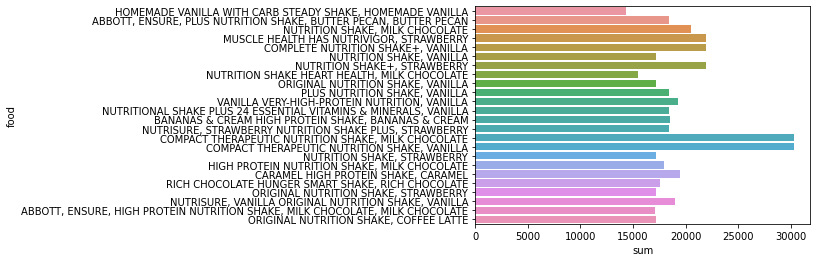

In [1401]:
barplot = sns.barplot(y="food", x="sum", data=usda);

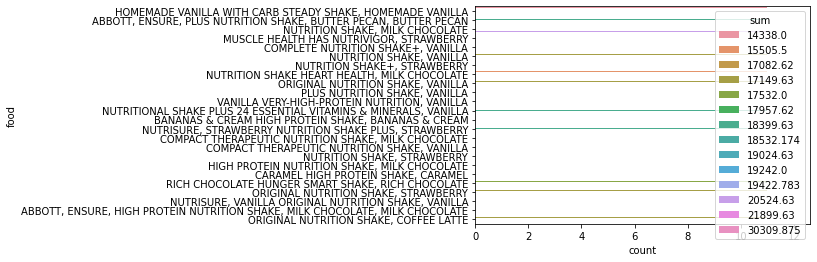

In [1400]:
sns.countplot(y=usda["food"], hue=usda["sum"]);

##### filter the DF.

## 2. HEALTH CARE web scraping.
### 2.1. Exploration.
Got the information from the page vedantu, about some nutrients and what causes the lak of them.
#### 2.1.1. Get the link.

In [1383]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import lxml
import importlib
import src.extraction as ex
importlib.reload(ex)

<module 'src.extraction' from 'd:\\ironhack\\proyectos\\PipeLine_proy2\\src\\extraction.py'>

In [1384]:
url = "https://www.vedantu.com/biology/deficiency-diseases"
tags = ex.get_text(url)

Filter the elements to the info we need.

In [1385]:
tag_1 = tags[37:55]
tag_2 = tags[60:68]
tag_3 = tags[73:91]

In [1386]:
info_1 = ex.text_filtered(tag_1)
info_2 = ex.text_filtered(tag_2)
info_3 = ex.text_filtered(tag_3)

Creating the lists into a data frame, it made it into a single column frame, had to separate the information into 2 columns, nutrients and the information, and at the end put the 3 data frames into 1.

In [1387]:
df = ex.db_concat (info_1, info_2, info_3)
df.reset_index(drop=True, inplace=True)
df

,nutrients,info
0,thiamine (vitamin b1),severe deficiency causes beriberi with symptom...
1,riboflavin (vitamin b2),the deficiency of this vitamin causes angular ...
2,niacin (vitamin b3),causes pellagra which is a life-threatening di...
3,pantothenic acid (vitamin b5),vitamin b5 deficiency is rare and the symptoms...
4,vitamin b6,end-stage kidney diseases such as celiac disea...
5,biotin (vitamin b7),the deficiency affects the growth of hair and ...
6,folate (vitamin b9),it is very common and the deficiency is associ...
7,vitamin b12,deficiency of this disease leads to pernicious...
8,ascorbic acid (vitamin c),deficiency results in scurvy and the symptoms ...
9,retinol (vitamin a),the deficiency causes night blindness or nycta...


Had to do the searching for the disease manually.

In [1388]:
lsttotal = list(df["info"])
lsttotal[20]

'the deficiency of phosphorus leads to the formation of underdeveloped teeth and bones.'

In [1389]:
lsttotal = list(df["info"])
lst0 = lsttotal[0]
lst1 = lsttotal[1]
lst2 = lsttotal[2]
lst3 = lsttotal[3]
lst4 = lsttotal[4]
lst5 = lsttotal[5]
lst6 = lsttotal[6]
lst7 = lsttotal[7]
lst8 = lsttotal[8]
lst9 = lsttotal[9]
lst10 = lsttotal[10]
lst11 = lsttotal[11]
lst12 = lsttotal[12]
lst13 = lsttotal[13]
lst14 = lsttotal[14]
lst15 = lsttotal[15]
lst16 = lsttotal[16]
lst17 = lsttotal[17]
lst18 = lsttotal[18]
lst19 = lsttotal[19]
lst20 = lsttotal[20]
lst21 = lsttotal[21]


In [1390]:
dis0 = ex.diseases (lst0)
dis1 = ex.diseases (lst1)
dis2 = ex.diseases (lst2)
dis3 = ex.diseases (lst3)
dis4 = ex.diseases (lst4)
dis5 = ex.diseases (lst5)
dis6 = ex.diseases (lst6)
dis7 = ex.diseases (lst7)
dis8 = ex.diseases (lst8)
dis9 = ex.diseases (lst9)
dis10 = ex.diseases (lst10)
dis11 = ex.diseases (lst11)
dis12 = ex.diseases (lst12)
dis13 = ex.diseases (lst13)
dis14 = ex.diseases (lst14)
dis15 = ex.diseases (lst15)
dis16 = ex.diseases (lst16)
dis17 = ex.diseases (lst17)
dis18 = ex.diseases (lst18)
dis19 = ex.diseases (lst19)
dis20 = ex.diseases (lst20)
dis21 = ex.diseases (lst21)

In [1391]:
lista = ex.diseases_total (dis0, dis1, dis2, dis3, dis4, dis5, dis6, dis7, dis8, dis9, dis10, dis11, dis12, dis13, dis14, dis15, dis16, dis17, dis18, dis19, dis20, dis21) 

Makiing them a data frame.

In [1392]:
enf = ex.df_diseases (lista)
enf.columns=["diseases"]
enf

,diseases
0,beriberi/ weight loss/ weakness
1,anaemia/ angular cheilitis/ chapped/ cracked lips
2,pellagra/ diarrhoea/ dermatitis/ dementia
3,fatigue/ apathy/ irritability
4,anaemia/ dermatitis/ celiac disease/ crohn/ ki...
5,skin health
6,neural tube defects
7,anaemia/ methylmalonic acidemia
8,scurvy/ skin spots
9,nyctalopia/ keratomalacia/ blindness


Merging the frames.

In [1393]:
disess = ex.df_concat (df, enf)
disess = disess.reindex(columns = ['nutrients','diseases','info'])
disess

,nutrients,diseases,info
0,thiamine (vitamin b1),beriberi/ weight loss/ weakness,severe deficiency causes beriberi with symptom...
1,riboflavin (vitamin b2),anaemia/ angular cheilitis/ chapped/ cracked lips,the deficiency of this vitamin causes angular ...
2,niacin (vitamin b3),pellagra/ diarrhoea/ dermatitis/ dementia,causes pellagra which is a life-threatening di...
3,pantothenic acid (vitamin b5),fatigue/ apathy/ irritability,vitamin b5 deficiency is rare and the symptoms...
4,vitamin b6,anaemia/ dermatitis/ celiac disease/ crohn/ ki...,end-stage kidney diseases such as celiac disea...
5,biotin (vitamin b7),skin health,the deficiency affects the growth of hair and ...
6,folate (vitamin b9),neural tube defects,it is very common and the deficiency is associ...
7,vitamin b12,anaemia/ methylmalonic acidemia,deficiency of this disease leads to pernicious...
8,ascorbic acid (vitamin c),scurvy/ skin spots,deficiency results in scurvy and the symptoms ...
9,retinol (vitamin a),nyctalopia/ keratomalacia/ blindness,the deficiency causes night blindness or nycta...
